# October ??th, 2021

**Motivation**: ?? <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import Allen
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from register.register import ants, reset_ants_img

## 128

In [3]:
mice = Mice(Config(128, 4, 100), load_preproc=True, load_allen=True, load_parcel=True)

### Load one individual Ca

In [4]:
key = 'sub-SLC08_ses-2'

mask = mice.mask2d[key].load_ants('unsigned int')

roi_2d = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz"),
    pixeltype='unsigned int',
)
roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
ref = ants.resample_image_to_target(ref, mask, interp_type='linear')

roi_2d *= mask
ref *= mask

<matplotlib.image.AxesImage object at 0x7f027b3e4cd0>

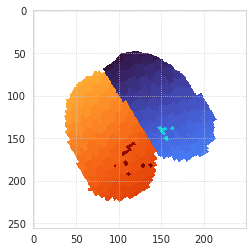

In [5]:
roi_2d_np = roi_2d.numpy().astype(int).squeeze()
regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])

roi_2d_np = roi_2d_np.astype(float)
roi_2d_np[roi_2d_np == 0] = np.nan

plt.imshow(roi_2d_np, cmap='turbo')

In [6]:
len(regions2d)

173

In [7]:
hcl = mice.parcel.decode(regions2d)[0]

In [8]:
sizes = collections.Counter(roi_2d_np[~np.isnan(roi_2d_np)])
sizes_np = np.array(list(sizes.values()))

In [9]:
min(sizes_np)

7

<AxesSubplot:ylabel='Count'>

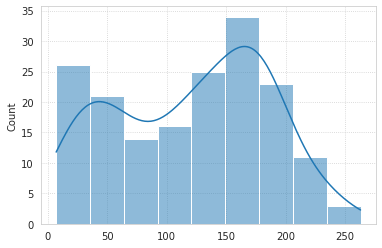

In [10]:
sns.histplot(sizes_np, kde=True)

In [11]:
sns.color_palette('hls', as_cmap=True)

<matplotlib.colors.ListedColormap object at 0x7f027b38ca30>

In [12]:
sns.color_palette('husl', as_cmap=True)

<matplotlib.colors.ListedColormap object at 0x7fe12c327fa0>

### Load all compare

In [14]:
flat = pjoin(mice.cfg.main_dir, 'parcel2d-flat_10um.nii.gz')
flat = ants.image_read(flat, pixeltype='unsigned int').numpy()
top = pjoin(mice.cfg.main_dir, 'parcel2d-top_10um.nii.gz')
top = ants.image_read(top, pixeltype='unsigned int').numpy()

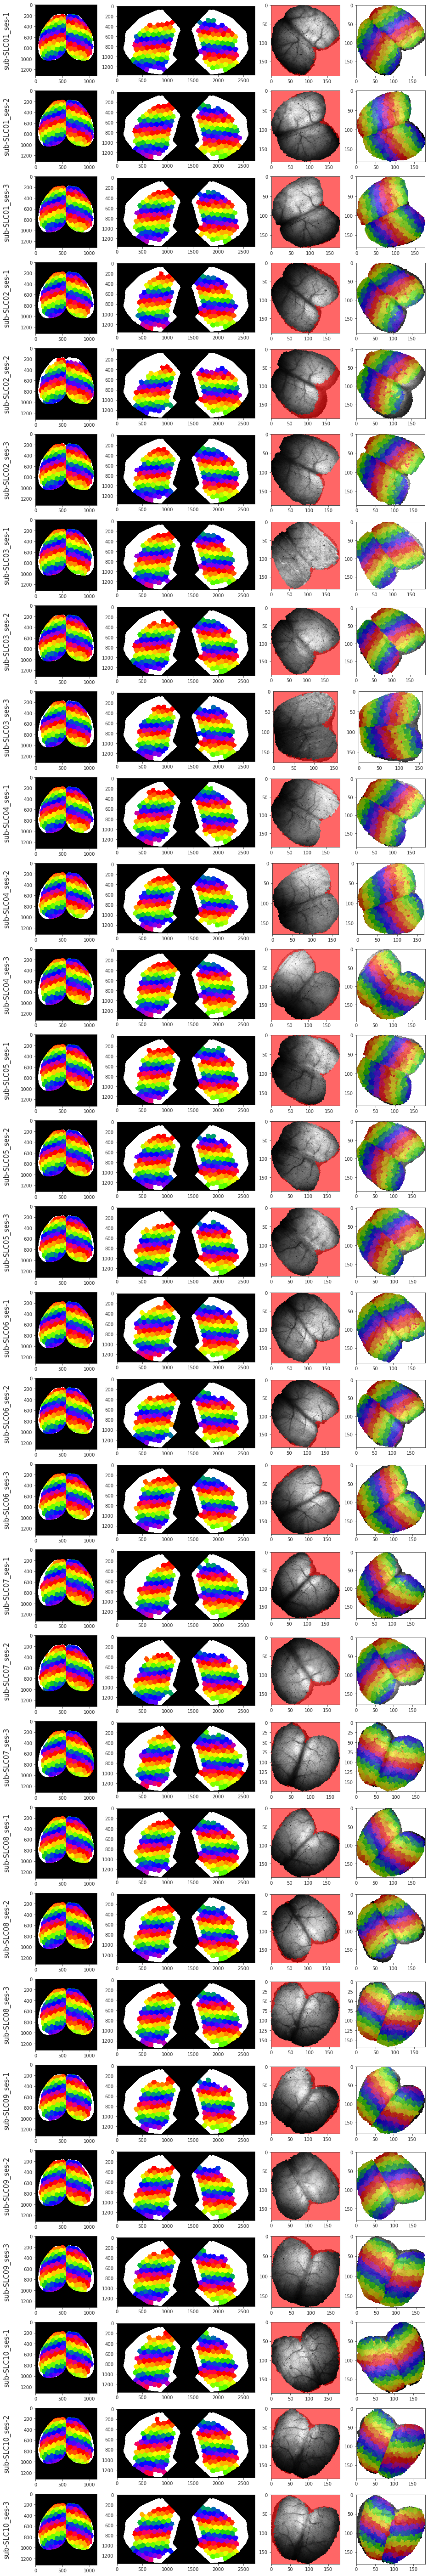

In [15]:
nrows = 30
fig, axes = create_figure(nrows, 4, (13, 2.6 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

dlist = []
regions_all = {}
for ii, key in enumerate(mice.ref):
    roi_2d = pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz")
    roi_2d = ants.image_read(filename=roi_2d, pixeltype='unsigned int')
    roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

    ref = mice.ref[key].load_ants('float')
    ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

    mask = mice.mask2d[key].load_ants('unsigned int')
    roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
    ref = ants.resample_image_to_target(ref, mask, interp_type='linear')
    roi_2d *= mask
    ref *= mask

    roi_2d_np = roi_2d.numpy().astype(int).squeeze()
    sizes = collections.Counter(roi_2d_np[roi_2d_np.nonzero()])
    dlist.append({
        'key': [key] * len(sizes),
        'region': sizes.keys(),
        'pixels': sizes.values(),
    })
    
    regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])
    regions_all[key] = list(regions2d)

    ref_tr, roi_tr, mask_tr = filter_boundaries(
        [ref.numpy(), roi_2d.numpy(), mask.numpy()], mask.numpy())
    ref_tr = ref_tr.astype(float)
    roi_tr = roi_tr.astype('uint32')
    mask_tr = mask_tr.astype(bool)
    
    axes[ii, 0].set_ylabel(f"{key}\n", fontsize=15)

    data2plt = np.ma.masked_where(~np.isin(top, regions2d), top)
    axes[ii, 0].imshow(top > 0, cmap='Greys_r')
    axes[ii, 0].imshow(data2plt, cmap='prism')

    data2plt = np.ma.masked_where(~np.isin(flat, regions2d), flat)
    axes[ii, 1].imshow(flat > 0, cmap='Greys_r')
    axes[ii, 1].imshow(data2plt, cmap='prism')

    axes[ii, 2].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 2].imshow(np.ma.masked_where(roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

    axes[ii, 3].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 3].imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

plt.show()

df_sz = pd.DataFrame(merge_dicts(dlist))

In [16]:
regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {i: 100 * v / 30 for i, v in freq.items()}

freq_top = np.zeros(top.shape)
freq_flat = np.zeros(flat.shape)

for i, val in freq.items():
    freq_top[top == i] = val
    freq_flat[flat == i] = val

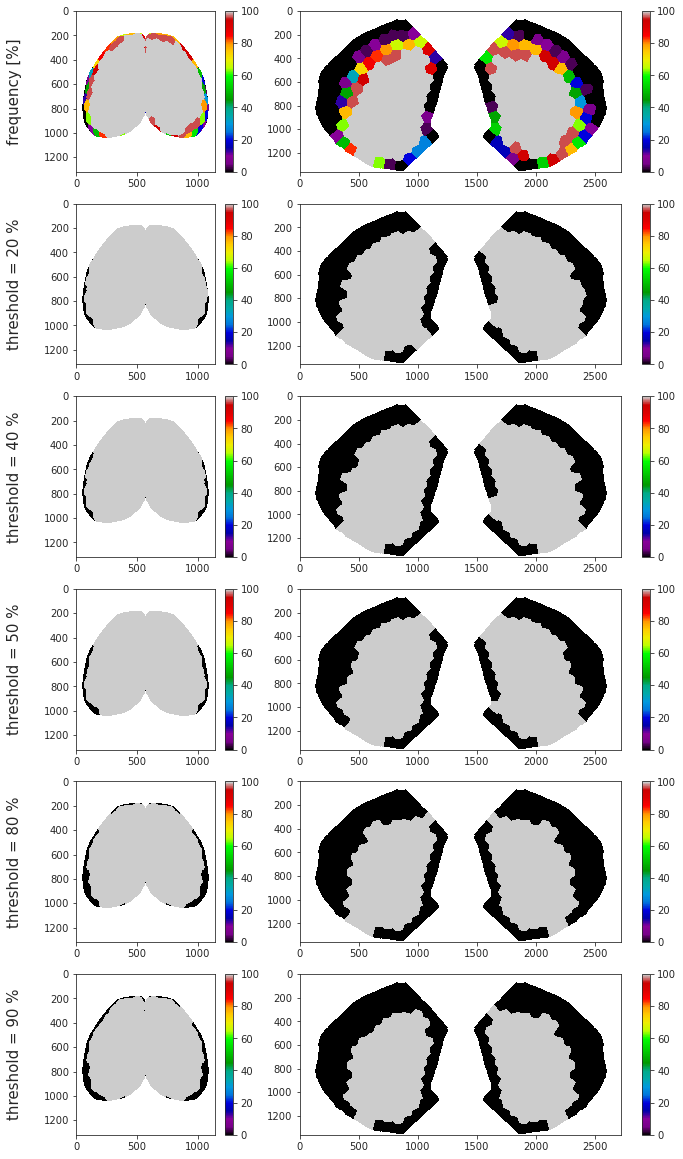

In [17]:
nrows = 6
fig, axes = create_figure(nrows, 2, (10, 2.7 * nrows), gridspec_kw={'width_ratios': [1, 2]})

axes[0, 0].set_ylabel('frequency [%]\n', fontsize=15)

data2plt = np.ma.masked_where(~top.astype(bool), freq_top)
im = axes[0, 0].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 0])

data2plt = np.ma.masked_where(~flat.astype(bool), freq_flat)
im = axes[0, 1].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 1])

for i, th in enumerate([20, 40, 50, 80, 90], start=1):
    axes[i, 0].set_ylabel(f"threshold = {th:d} %\n", fontsize=15)
    
    x = freq_top.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~top.astype(bool), x)
    im = axes[i, 0].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 0])

    x = freq_flat.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~flat.astype(bool), x)
    im = axes[i, 1].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 1])

plt.show()

In [18]:
len(freq)

262

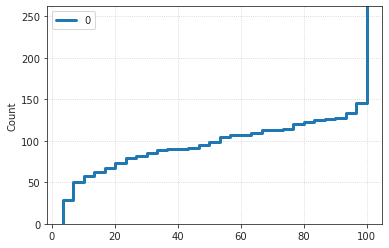

In [19]:
sns.ecdfplot(freq.values(), stat='count', lw=3)
plt.grid()

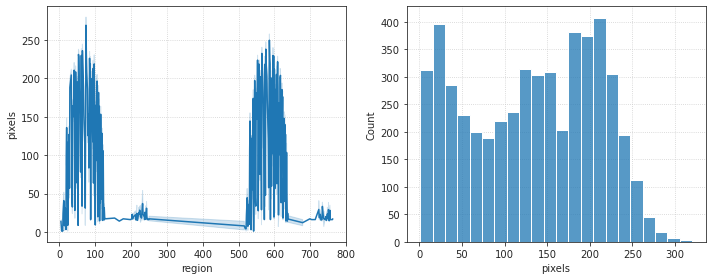

In [20]:
fig, axes = create_figure(1, 2, (10, 4))

sns.lineplot(data=df_sz, x='region', y='pixels', ax=axes[0])
sns.histplot(data=df_sz, x='pixels', ax=axes[1])
for ax in axes.ravel():
    ax.grid()

plt.show()

<matplotlib.image.AxesImage object at 0x7f01cc242f70>

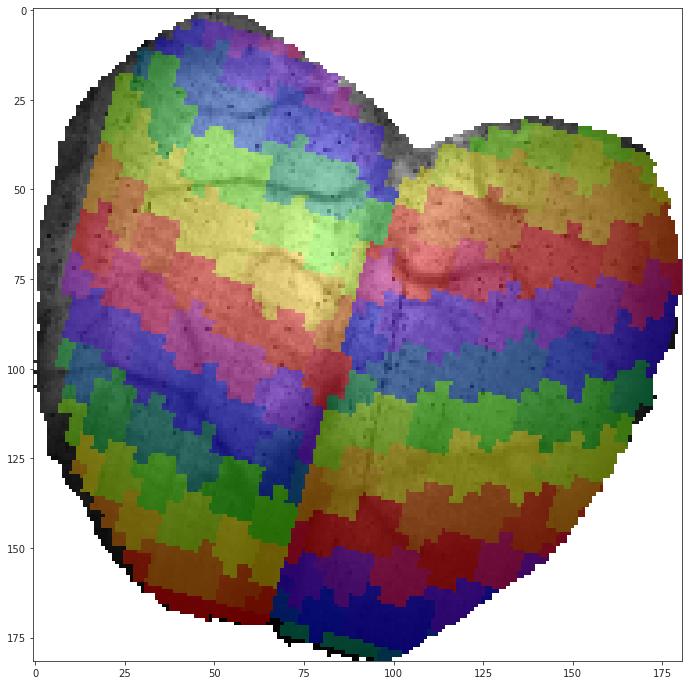

In [21]:
plt.figure(figsize=(15, 12))
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.4, cmap='prism')

## 512

In [21]:
mice = Mice(Config(512, 4, 100), load_preproc=True, load_allen=True, load_parcel=True)

### Load all compare

In [22]:
flat = pjoin(mice.cfg.main_dir, 'parcel2d-flat_10um.nii.gz')
flat = ants.image_read(flat, pixeltype='unsigned int').numpy()
top = pjoin(mice.cfg.main_dir, 'parcel2d-top_10um.nii.gz')
top = ants.image_read(top, pixeltype='unsigned int').numpy()

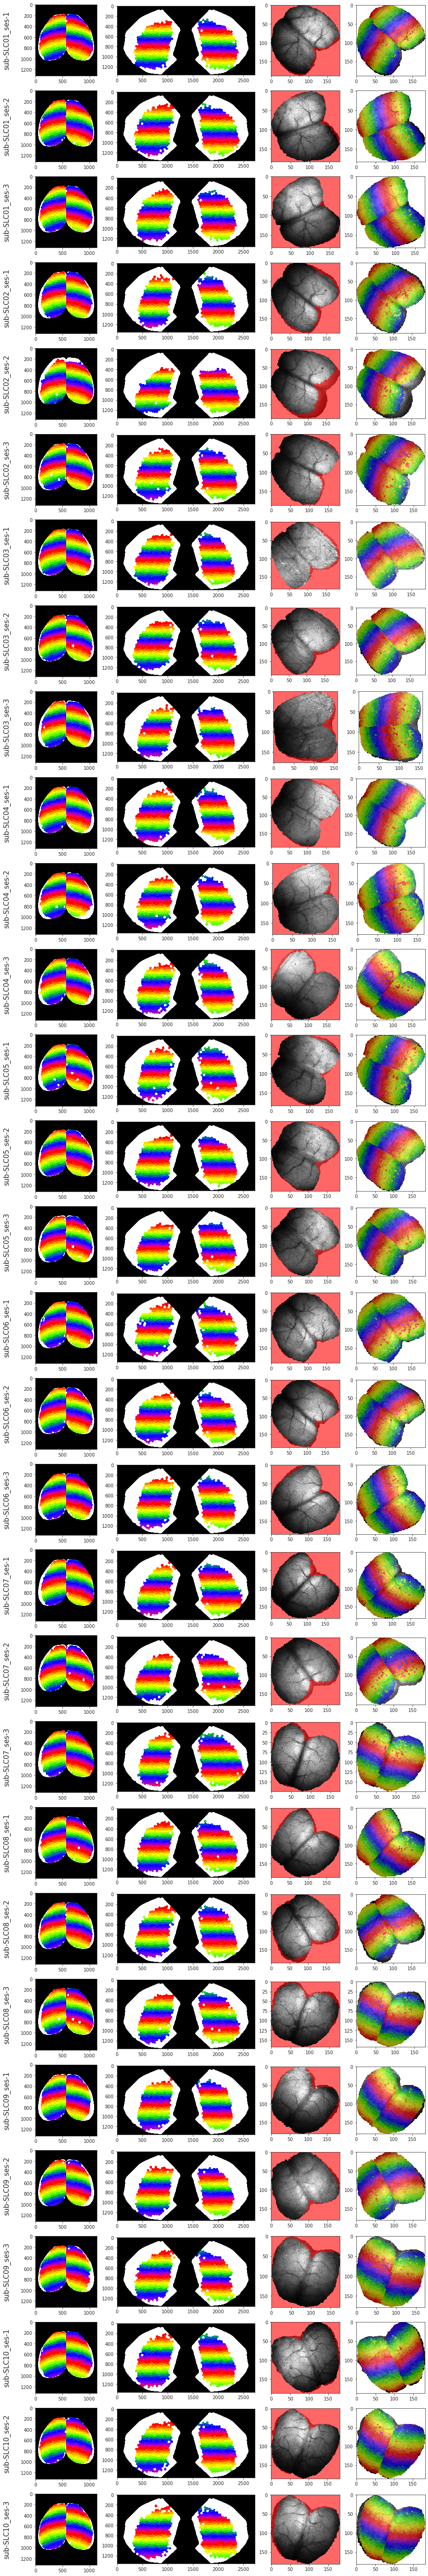

In [23]:
nrows = 30
fig, axes = create_figure(nrows, 4, (13, 2.6 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

dlist = []
regions_all = {}
for ii, key in enumerate(mice.ref):
    roi_2d = pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz")
    roi_2d = ants.image_read(filename=roi_2d, pixeltype='unsigned int')
    roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

    ref = mice.ref[key].load_ants('float')
    ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

    mask = mice.mask2d[key].load_ants('unsigned int')
    roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
    ref = ants.resample_image_to_target(ref, mask, interp_type='linear')
    roi_2d *= mask
    ref *= mask

    roi_2d_np = roi_2d.numpy().astype(int).squeeze()
    sizes = collections.Counter(roi_2d_np[roi_2d_np.nonzero()])
    dlist.append({
        'key': [key] * len(sizes),
        'region': sizes.keys(),
        'pixels': sizes.values(),
    })
    
    regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])
    regions_all[key] = list(regions2d)

    ref_tr, roi_tr, mask_tr = filter_boundaries(
        [ref.numpy(), roi_2d.numpy(), mask.numpy()], mask.numpy())
    ref_tr = ref_tr.astype(float)
    roi_tr = roi_tr.astype('uint32')
    mask_tr = mask_tr.astype(bool)
    
    axes[ii, 0].set_ylabel(f"{key}\n", fontsize=15)

    data2plt = np.ma.masked_where(~np.isin(top, regions2d), top)
    axes[ii, 0].imshow(top > 0, cmap='Greys_r')
    axes[ii, 0].imshow(data2plt, cmap='prism')

    data2plt = np.ma.masked_where(~np.isin(flat, regions2d), flat)
    axes[ii, 1].imshow(flat > 0, cmap='Greys_r')
    axes[ii, 1].imshow(data2plt, cmap='prism')

    axes[ii, 2].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 2].imshow(np.ma.masked_where(roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

    axes[ii, 3].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
    axes[ii, 3].imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

plt.show()

df_sz = pd.DataFrame(merge_dicts(dlist))

In [24]:
regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {i: 100 * v / 30 for i, v in freq.items()}

freq_top = np.zeros(top.shape)
freq_flat = np.zeros(flat.shape)

for i, val in freq.items():
    freq_top[top == i] = val
    freq_flat[flat == i] = val

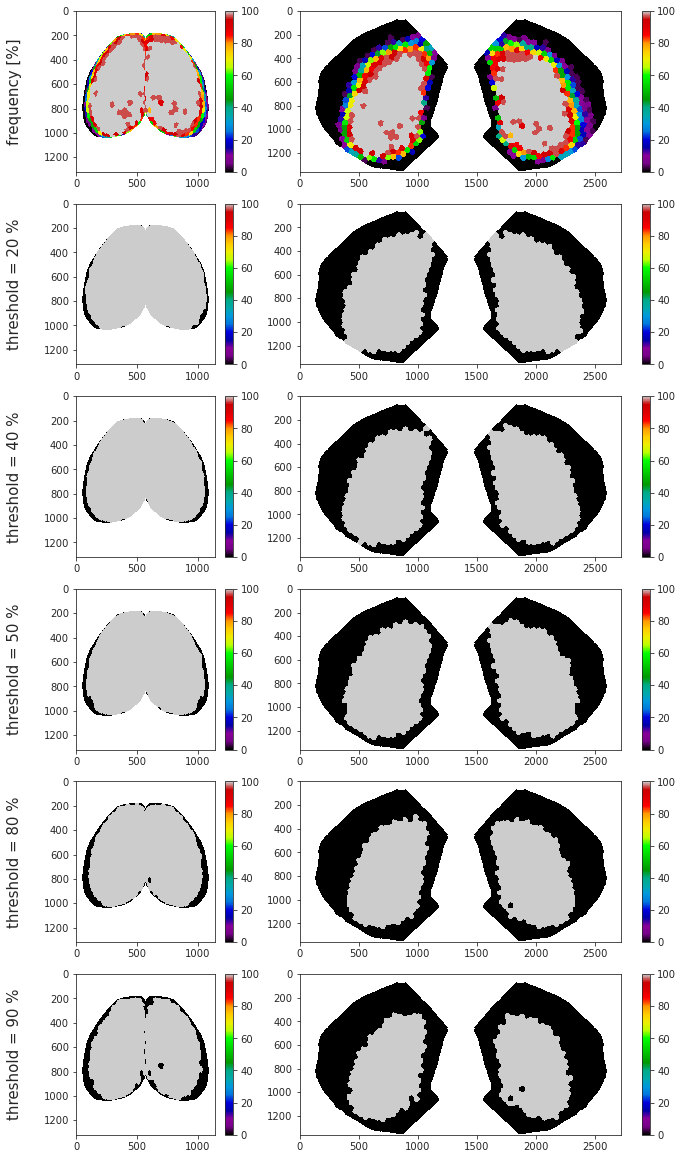

In [25]:
nrows = 6
fig, axes = create_figure(nrows, 2, (10, 2.7 * nrows), gridspec_kw={'width_ratios': [1, 2]})

axes[0, 0].set_ylabel('frequency [%]\n', fontsize=15)

data2plt = np.ma.masked_where(~top.astype(bool), freq_top)
im = axes[0, 0].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 0])

data2plt = np.ma.masked_where(~flat.astype(bool), freq_flat)
im = axes[0, 1].imshow(data2plt, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0, 1])

for i, th in enumerate([20, 40, 50, 80, 90], start=1):
    axes[i, 0].set_ylabel(f"threshold = {th:d} %\n", fontsize=15)
    
    x = freq_top.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~top.astype(bool), x)
    im = axes[i, 0].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 0])

    x = freq_flat.copy()
    x[x > th] = 100.
    x[x <= th] = 0.
    data2plt = np.ma.masked_where(~flat.astype(bool), x)
    im = axes[i, 1].imshow(data2plt, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[i, 1])

plt.show()

In [26]:
len(freq)

893

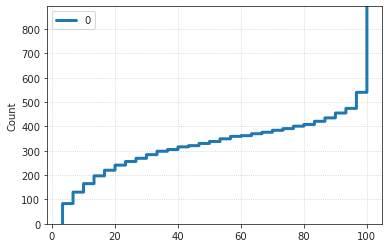

In [27]:
sns.ecdfplot(freq.values(), stat='count', lw=3)
plt.grid()

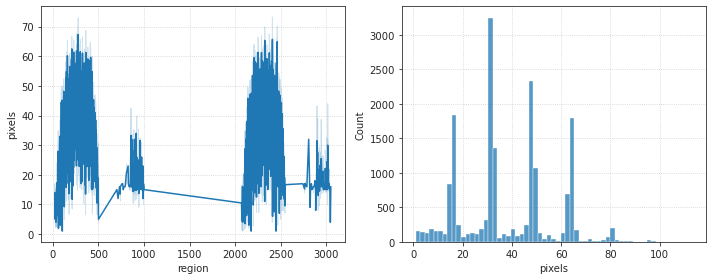

In [28]:
fig, axes = create_figure(1, 2, (10, 4))

sns.lineplot(data=df_sz, x='region', y='pixels', ax=axes[0])
sns.histplot(data=df_sz, x='pixels', ax=axes[1])
for ax in axes.ravel():
    ax.grid()

plt.show()

<matplotlib.image.AxesImage object at 0x7ec9ebaf0640>

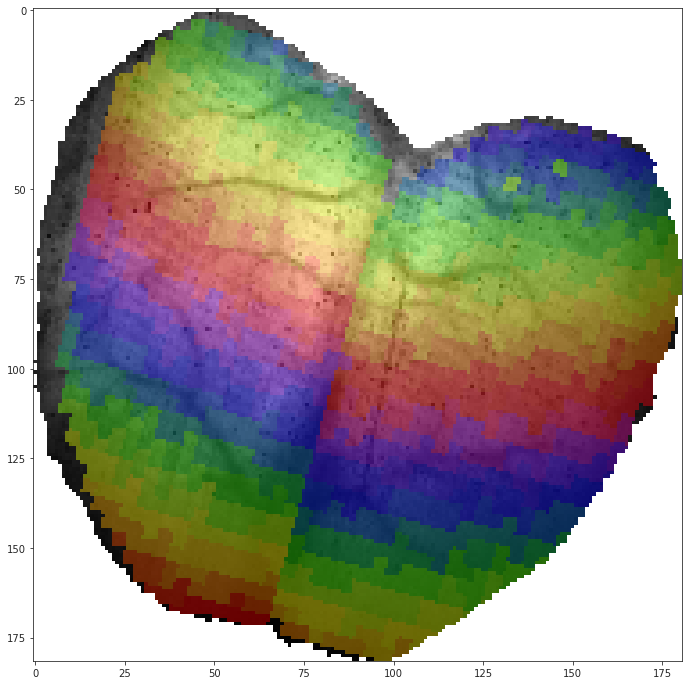

In [29]:
plt.figure(figsize=(15, 12))
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.4, cmap='prism')

### Why layer 1 appears? (it should all be layer 0)

In [31]:
key = 'sub-SLC07_ses-2'

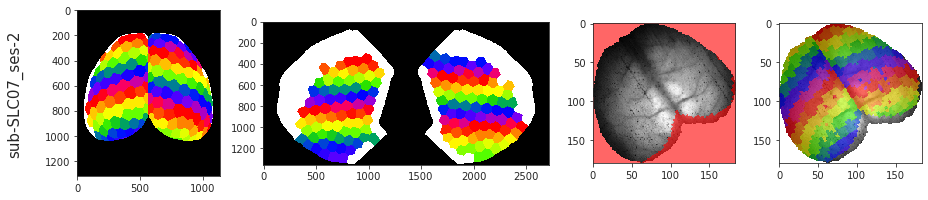

In [32]:
fig, axes = create_figure(1, 4, (13, 2.6 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

roi_2d = pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz")
roi_2d = ants.image_read(filename=roi_2d, pixeltype='unsigned int')
roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

mask = mice.mask2d[key].load_ants('unsigned int')
roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
ref = ants.resample_image_to_target(ref, mask, interp_type='linear')
roi_2d *= mask
ref *= mask

roi_2d_np = roi_2d.numpy().astype(int).squeeze()
sizes = collections.Counter(roi_2d_np[roi_2d_np.nonzero()])

regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])
regions_all[key] = list(regions2d)

ref_tr, roi_tr, mask_tr = filter_boundaries(
    [ref.numpy(), roi_2d.numpy(), mask.numpy()], mask.numpy())
ref_tr = ref_tr.astype(float)
roi_tr = roi_tr.astype('uint32')
mask_tr = mask_tr.astype(bool)

axes[0].set_ylabel(f"{key}\n", fontsize=15)

data2plt = np.ma.masked_where(~np.isin(top, regions2d), top)
axes[0].imshow(top > 0, cmap='Greys_r')
axes[0].imshow(data2plt, cmap='prism')

data2plt = np.ma.masked_where(~np.isin(flat, regions2d), flat)
axes[1].imshow(flat > 0, cmap='Greys_r')
axes[1].imshow(data2plt, cmap='prism')

axes[2].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
axes[2].imshow(np.ma.masked_where(roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

axes[3].imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
axes[3].imshow(np.ma.masked_where(~roi_tr.astype(bool), roi_tr), alpha=0.6, cmap='prism')

plt.show()

In [33]:
sizes_np = np.array(list(sizes.values()))
min(sizes_np)

1

<AxesSubplot:ylabel='Count'>

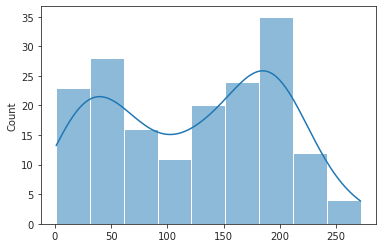

In [34]:
sns.histplot(sizes_np, kde=True)

In [35]:
hcl = mice.parcel.decode(regions2d)[0]

In [36]:
lay0 = regions2d[hcl[:, -1] == 0]
lay1 = regions2d[hcl[:, -1] == 1]

<matplotlib.image.AxesImage object at 0x7f01c7b1deb0>

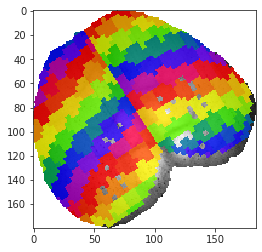

In [37]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay0), roi_tr), alpha=0.8, cmap='prism')

<matplotlib.image.AxesImage object at 0x7f01c7a974c0>

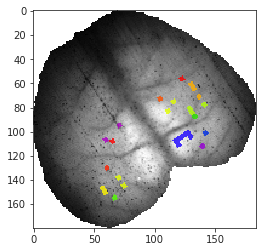

In [38]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr), alpha=0.8, cmap='prism')

In [39]:
hcl_lay1 = mice.parcel.decode(lay1)[0]
hcl_lay1[:, -1] = 0
lay1_to_0 = mice.parcel.encode(hcl_lay1)

<matplotlib.image.AxesImage object at 0x7f01c7ac3040>

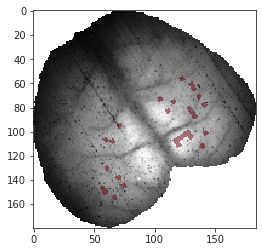

In [41]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr).astype(bool), alpha=0.5, cmap='Reds_r')
# plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1_to_0), roi_tr).astype(bool), alpha=0.5, cmap='Greens_r')

<matplotlib.image.AxesImage object at 0x7f01c79f9370>

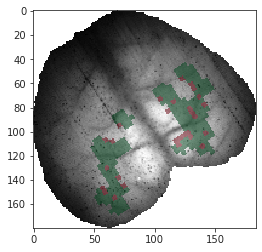

In [42]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr).astype(bool), alpha=0.5, cmap='Reds_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1_to_0), roi_tr).astype(bool), alpha=0.5, cmap='Greens_r')

<matplotlib.image.AxesImage object at 0x7f01c7a6f0d0>

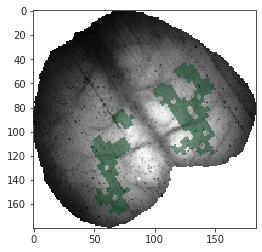

In [43]:
plt.imshow(np.ma.masked_where(~mask_tr, ref_tr), cmap='Greys_r')
# plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1), roi_tr).astype(bool), alpha=0.5, cmap='Reds_r')
plt.imshow(np.ma.masked_where(~np.isin(roi_tr, lay1_to_0), roi_tr).astype(bool), alpha=0.5, cmap='Greens_r')